In [1]:
import sys
import os
import pathlib
import glob
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from dateutil import parser
# from datetime import datetime, timedelta
import sweetviz as sv

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from flexitext import flexitext

In [2]:
%load_ext autoreload
%autoreload 2

from helper_functions import visualization

In [3]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"

# Data Loading and Preprocessing

In [4]:
# Import the data
raw_klhk_jkt_dir = raw_data_dir / "klhk_jkt"
klhk_jkt_list = glob.glob(f'{str(raw_klhk_jkt_dir)}/*.xlsx')

In [5]:
raw_df = pd.concat([pd.read_excel(file) for file in klhk_jkt_list])
raw_df.head(2)

,Stasiun,Tanggal,Waktu,PM10,PM2.5,SO2,CO,O3,NO2,HC,PM 2.5 Sedang,PM 2.5 Tidak Sehat
0,Bantar Gebang,2023-06-01,00:00:00,93.0,131.0,0.0,22,12.0,9.0,0.0,55.4,150.4
1,Bantar Gebang,2023-06-01,01:00:00,91.0,129.0,0.0,22,12.0,9.0,0.0,55.4,150.4


In [6]:
# standardize column names
col_name_mapping = {_: _.lower() for _ in raw_df.columns}
processed_df = raw_df.copy()
processed_df = processed_df.rename(columns=col_name_mapping)

# create read_time column as datetime
processed_df['read_time'] = pd.to_datetime(processed_df['tanggal'].astype("str") + ' ' + processed_df['waktu'])
processed_df.drop(['tanggal', 'waktu'], axis=1, inplace=True)
processed_df = processed_df.sort_values(by=['stasiun', 'read_time'])

# there's "x" value in "co" column
processed_df['co'] = pd.to_numeric(processed_df['co'], errors='coerce')

# impute null values
# pm10, pm2.5, so2, co, o3, no2, hc
# https://drnesr.medium.com/filling-gaps-of-a-time-series-using-python-d4bfddd8c460
# https://www.section.io/engineering-education/missing-values-in-time-series/
processed_df = processed_df.assign(InterpolateLinear=processed_df['pm2.5'].interpolate(method='linear'))

In [9]:
processed_df.head(2)

,stasiun,pm10,pm2.5,so2,co,o3,no2,hc,pm 2.5 sedang,pm 2.5 tidak sehat,read_time,InterpolateLinear
0,Bantar Gebang,93.0,131.0,0.0,22.0,12.0,9.0,0.0,55.4,150.4,2023-06-01 00:00:00,131.0
1,Bantar Gebang,91.0,129.0,0.0,22.0,12.0,9.0,0.0,55.4,150.4,2023-06-01 01:00:00,129.0


# Exploratory Data Analysis

                                             |          | [  0%]   00:00 -> (? left)


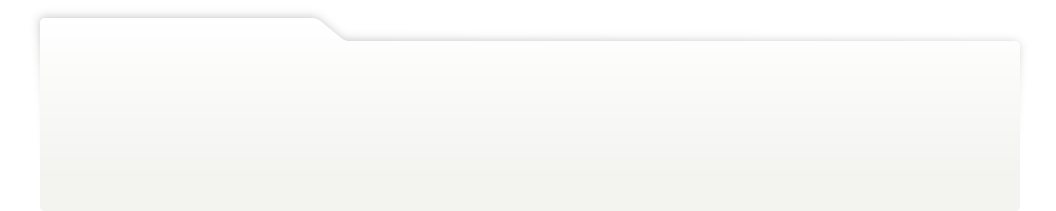
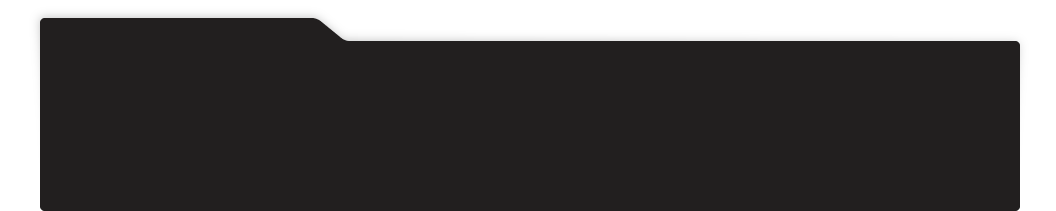
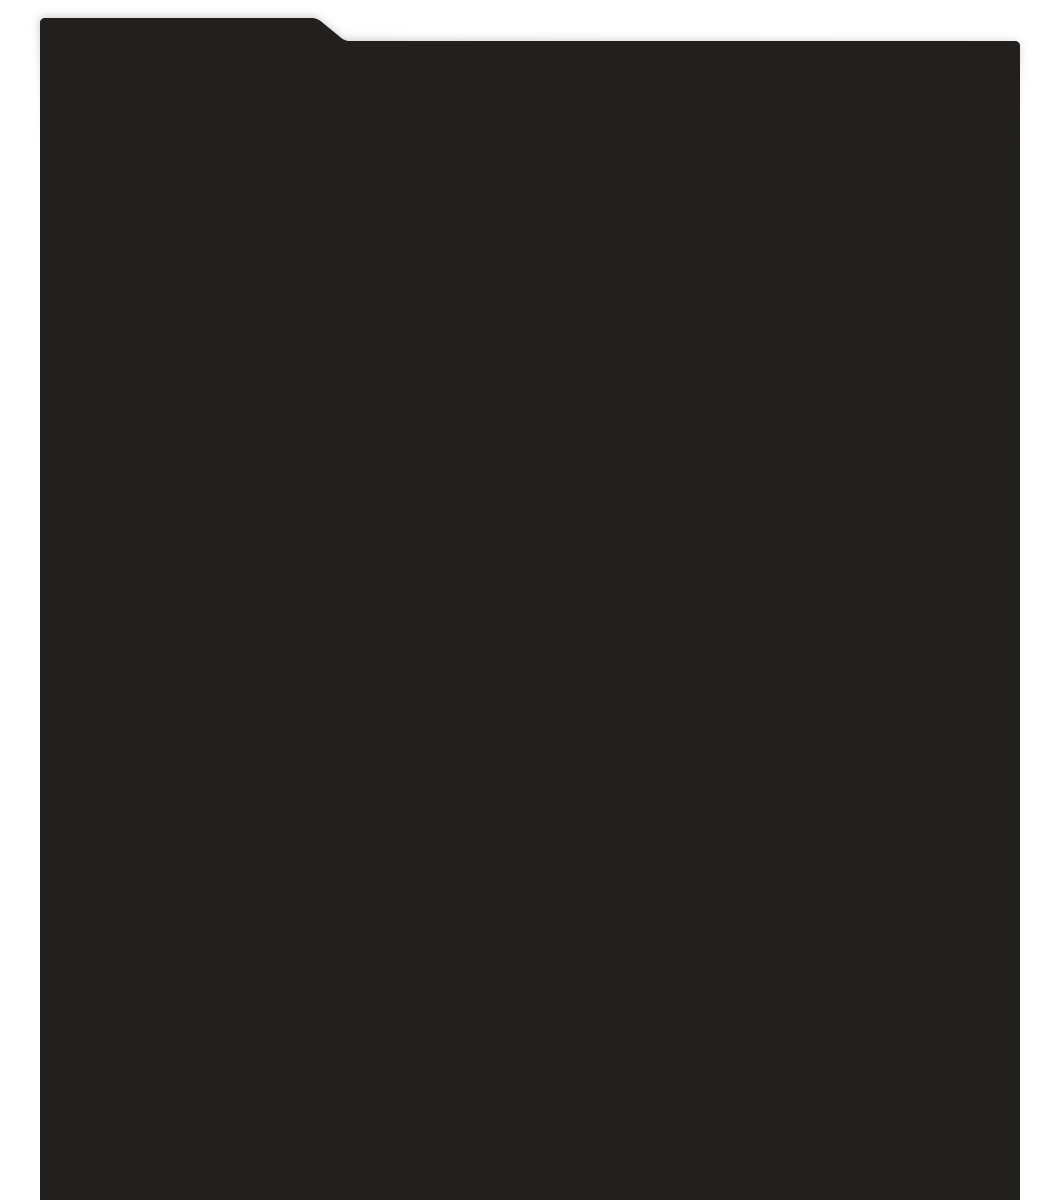
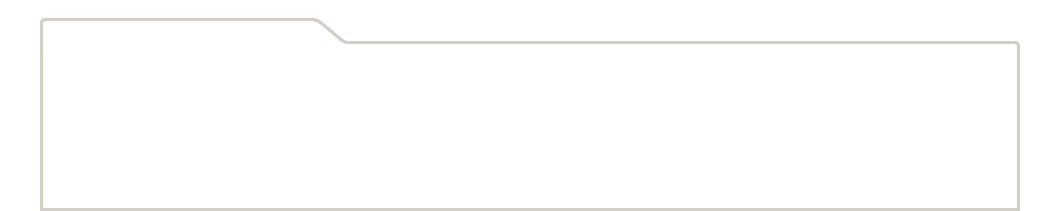
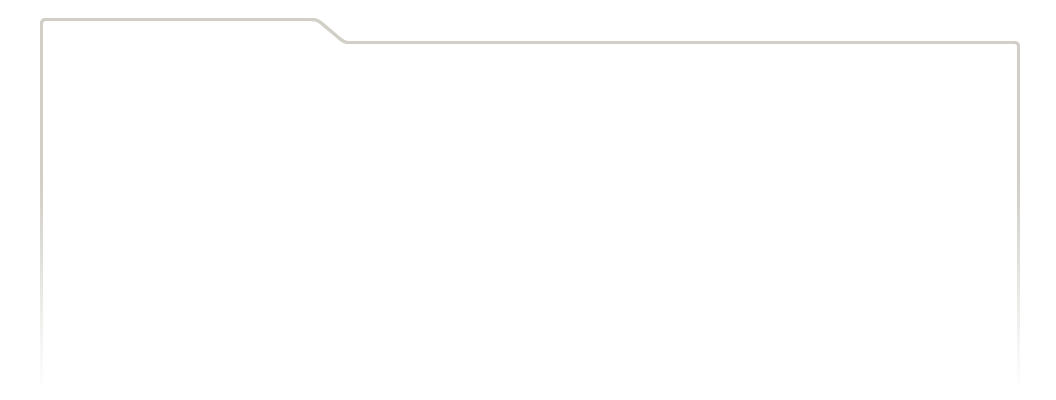
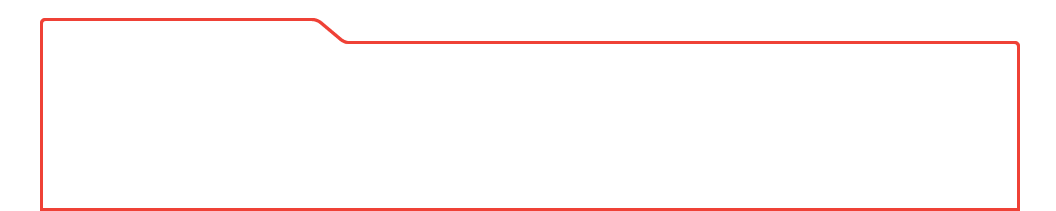
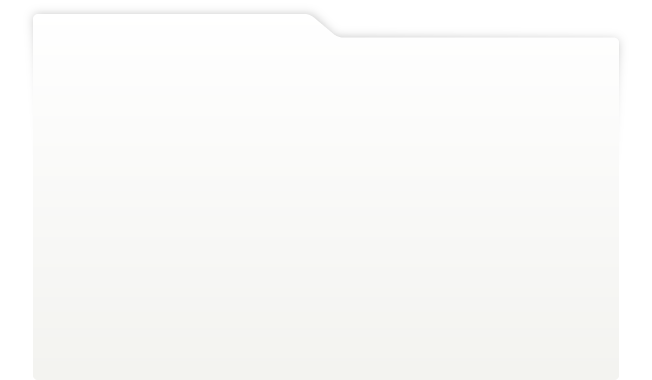
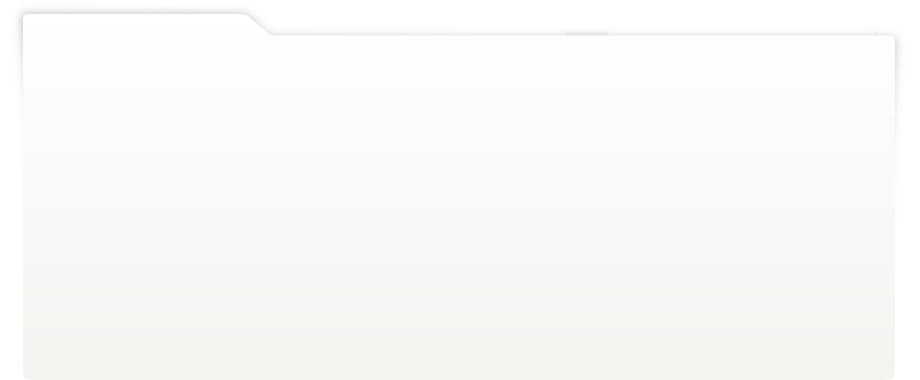
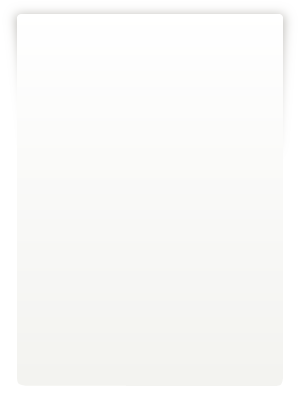
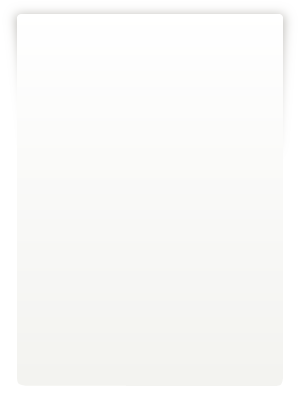
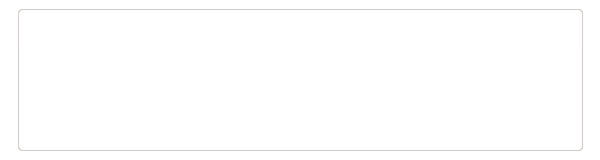
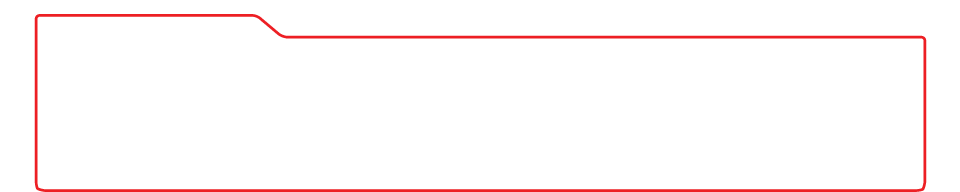
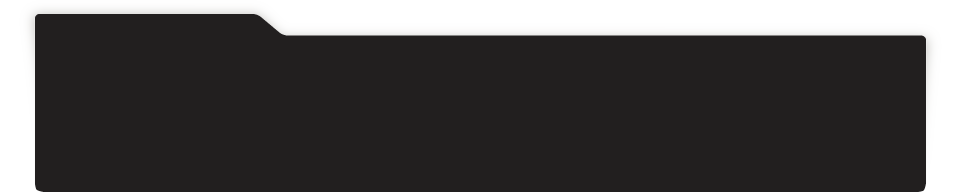
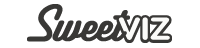
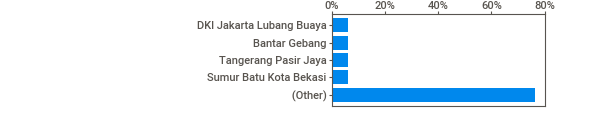
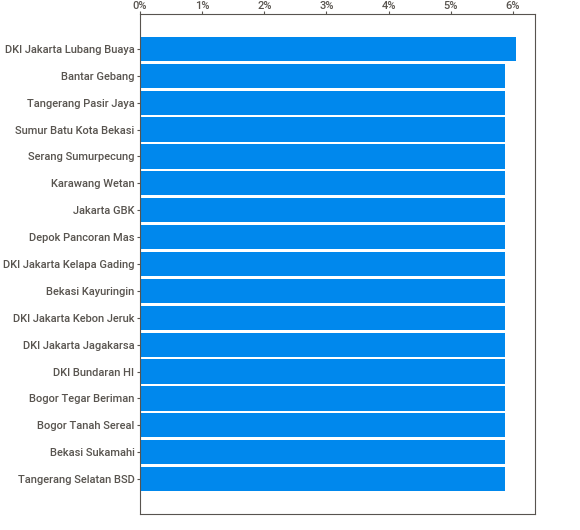
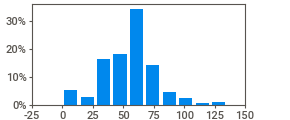
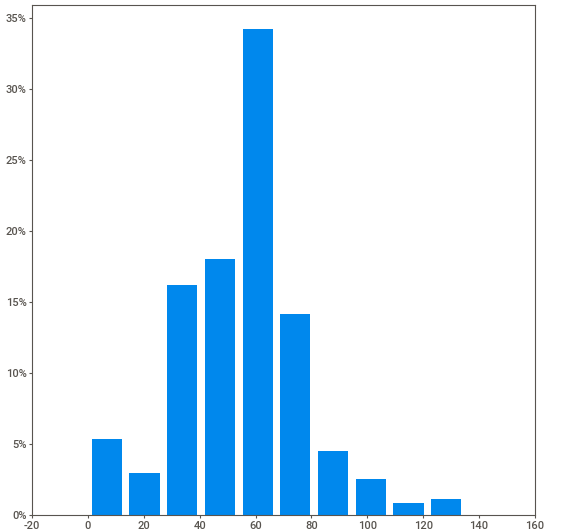
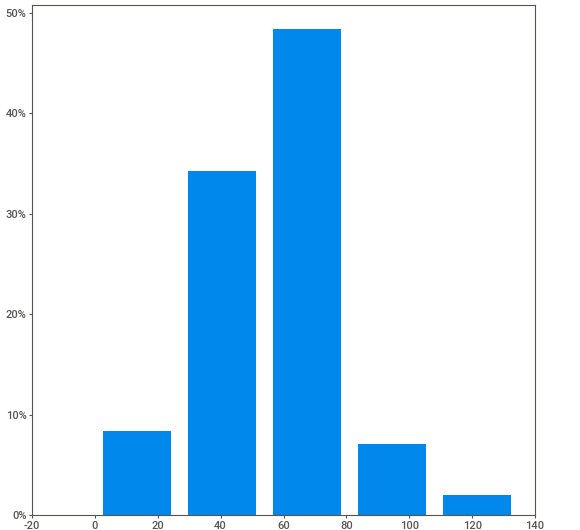
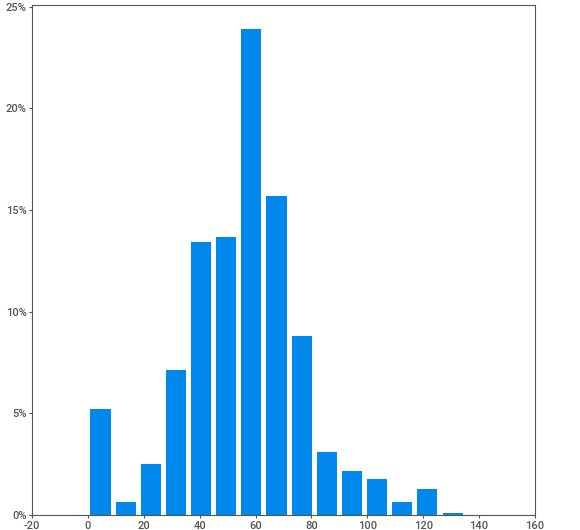
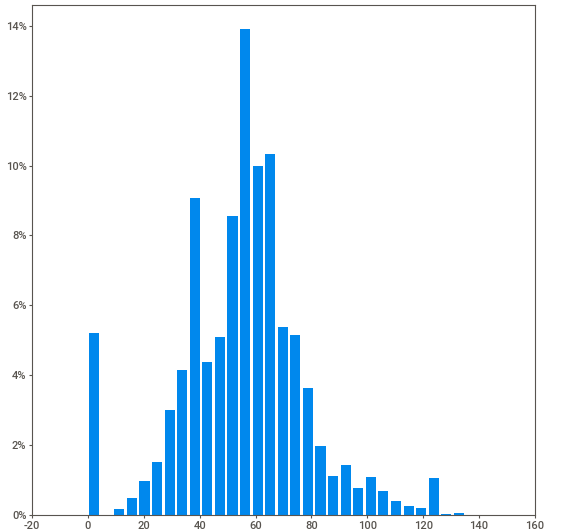
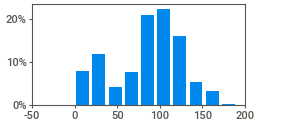
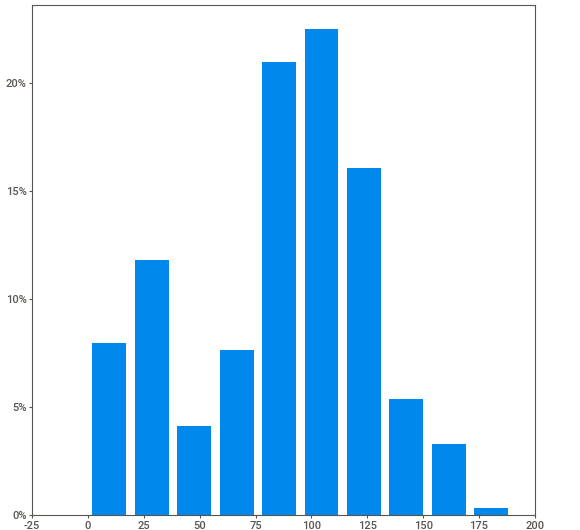
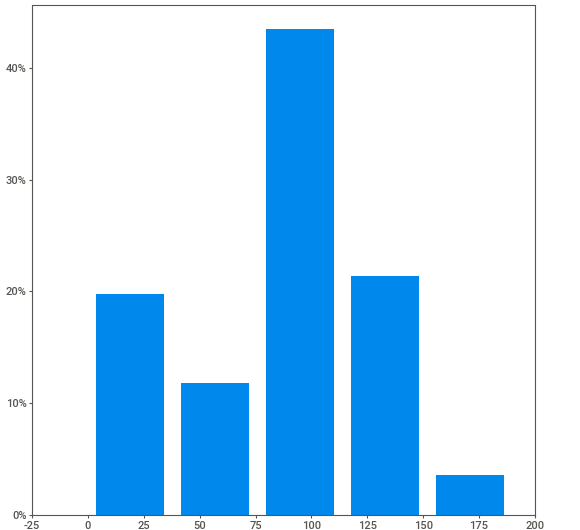
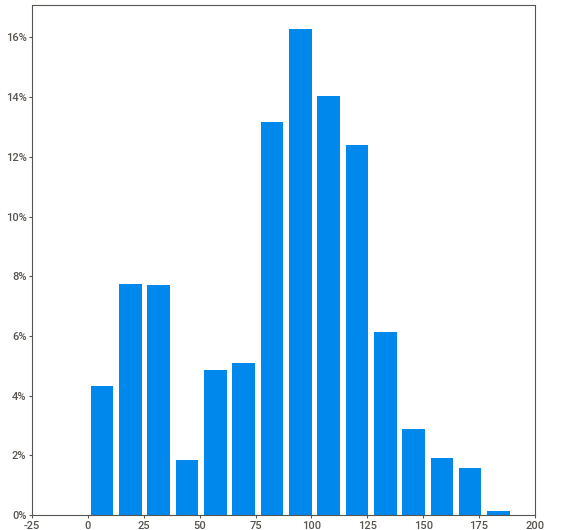
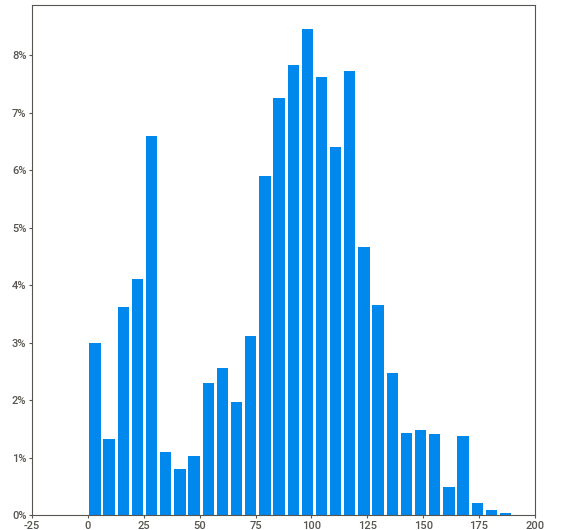
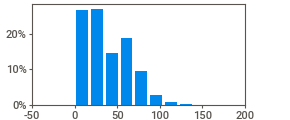
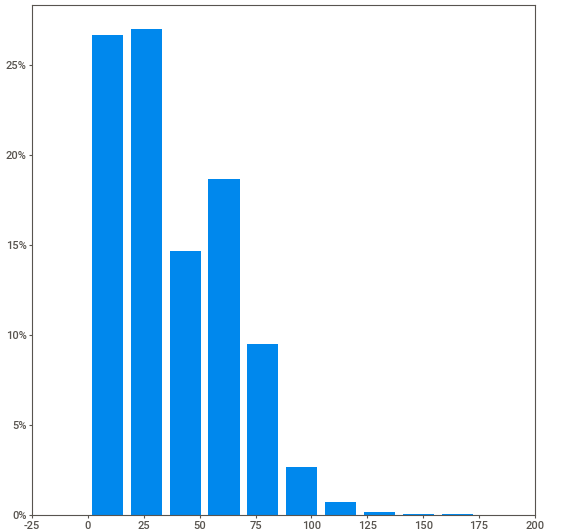
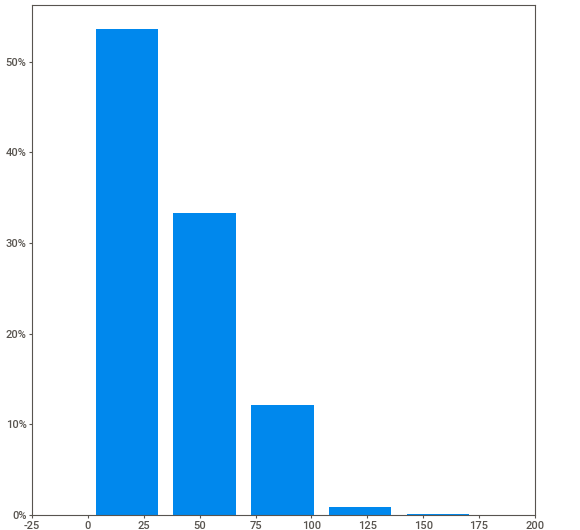
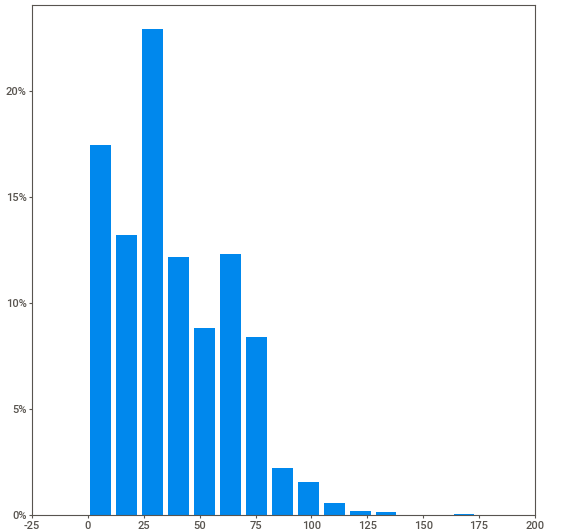
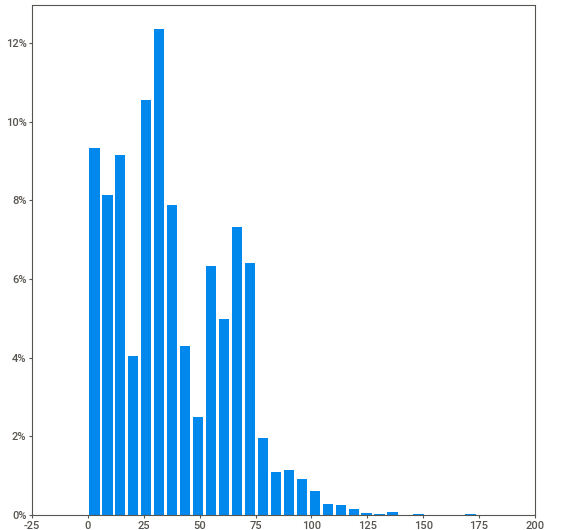
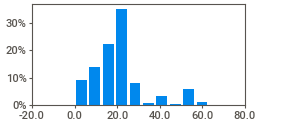
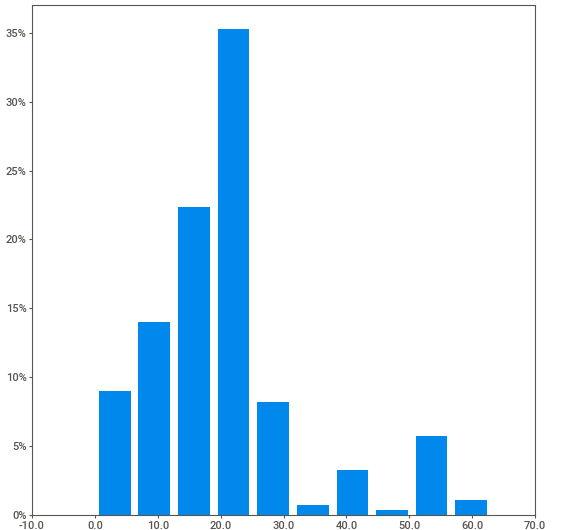
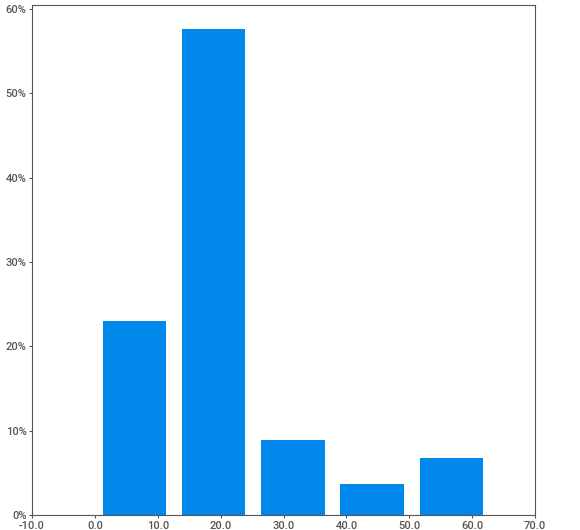
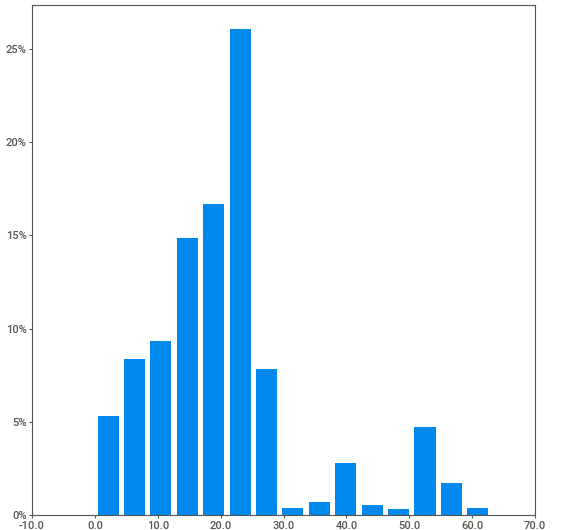
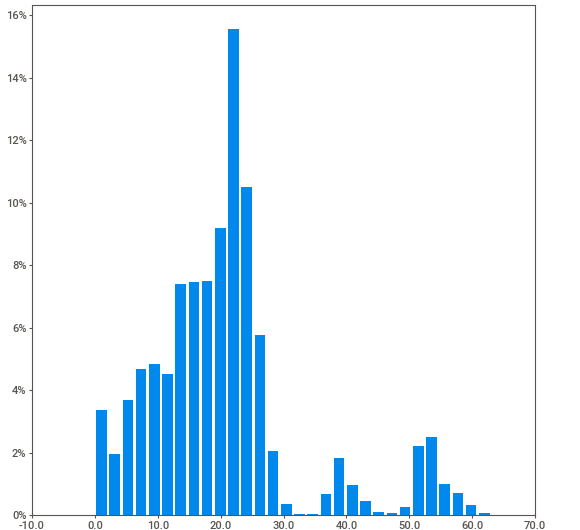
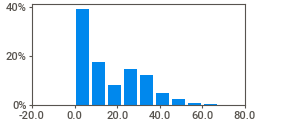
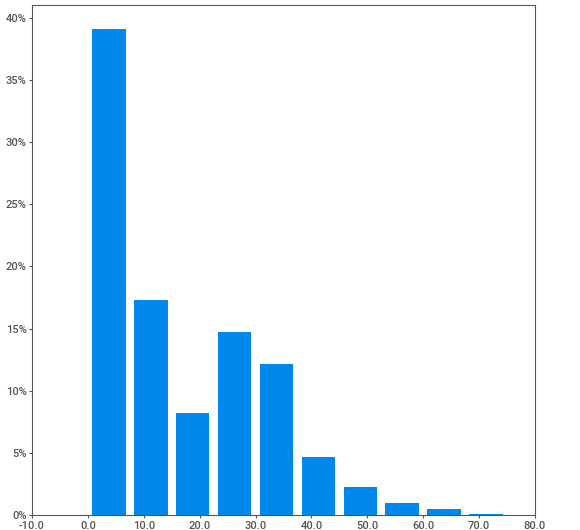
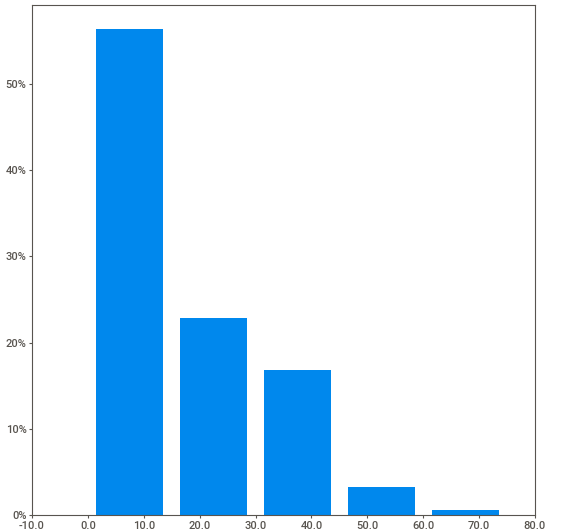
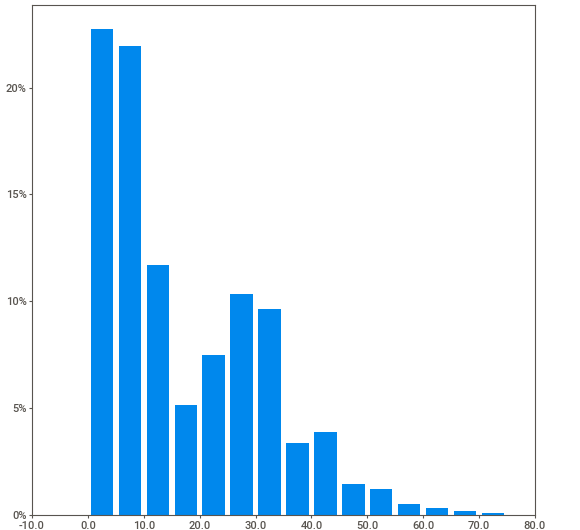
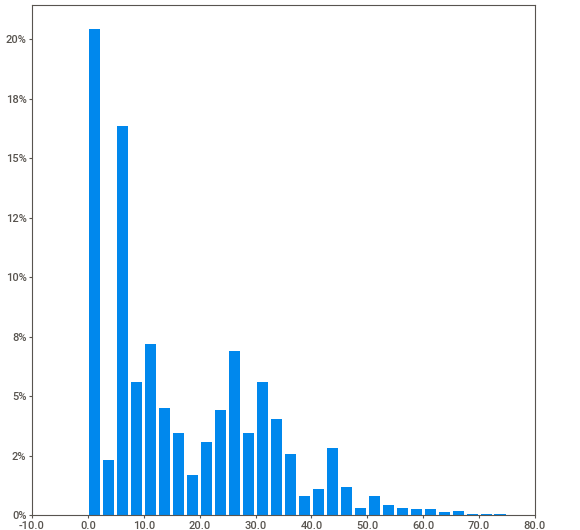
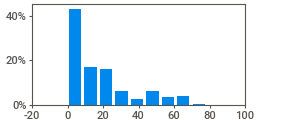
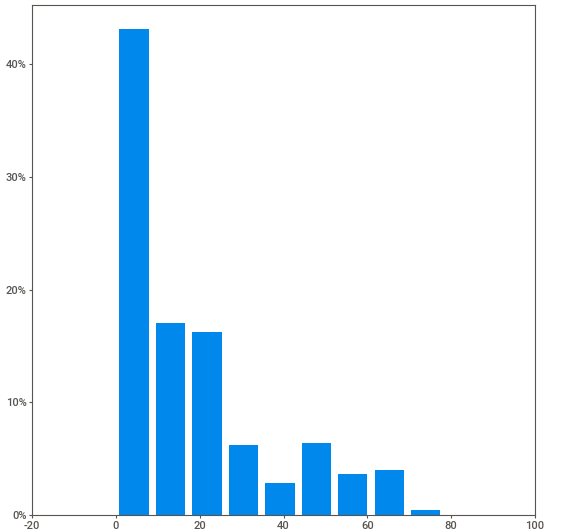
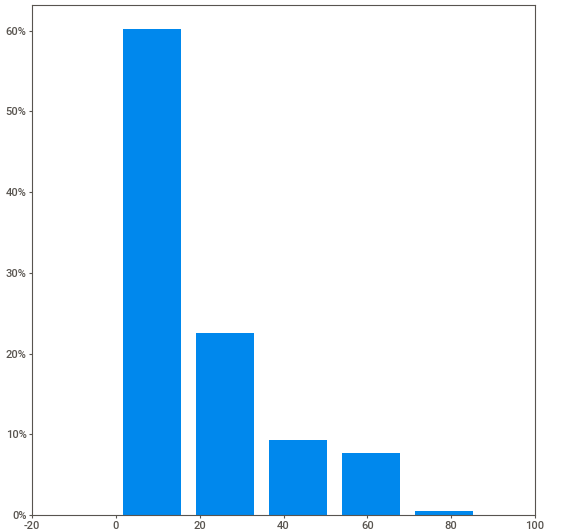
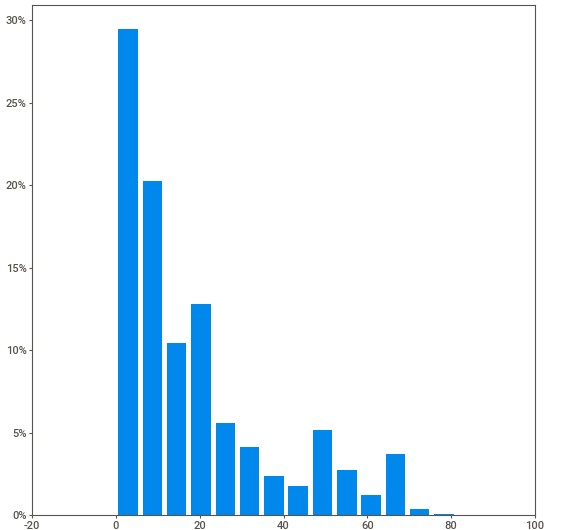
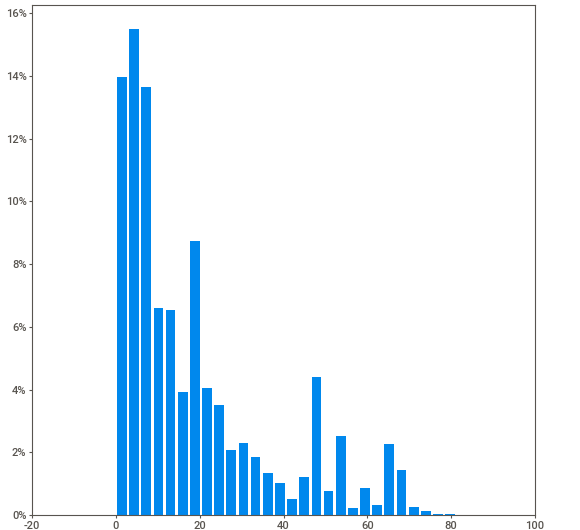
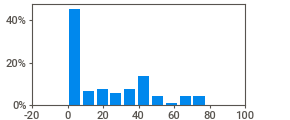
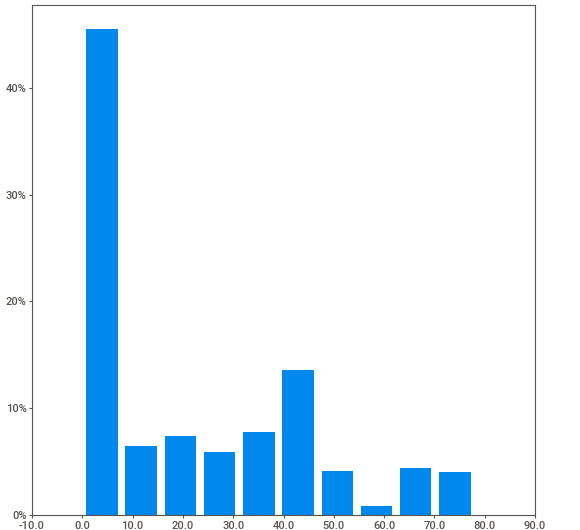
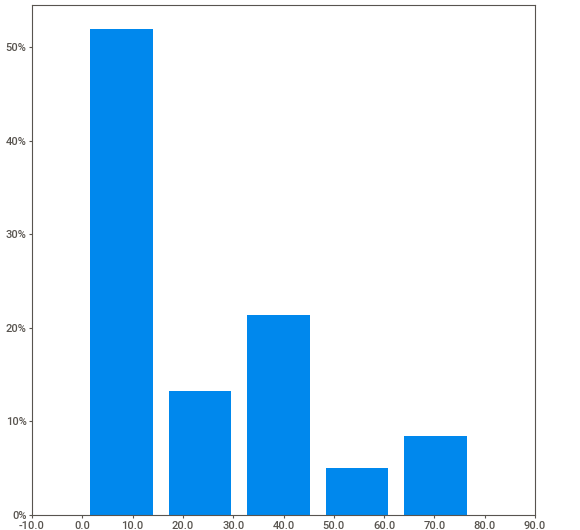
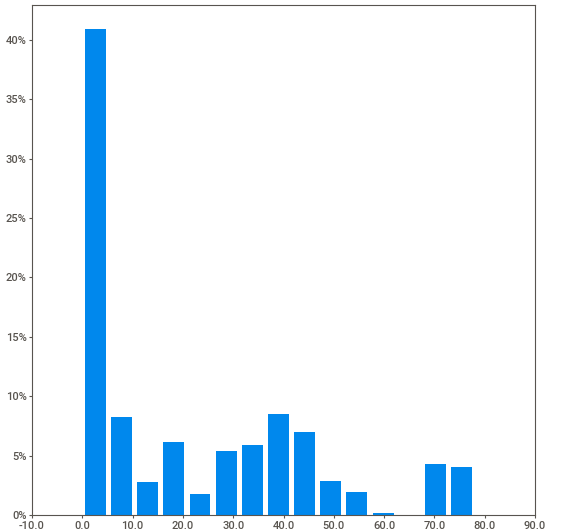
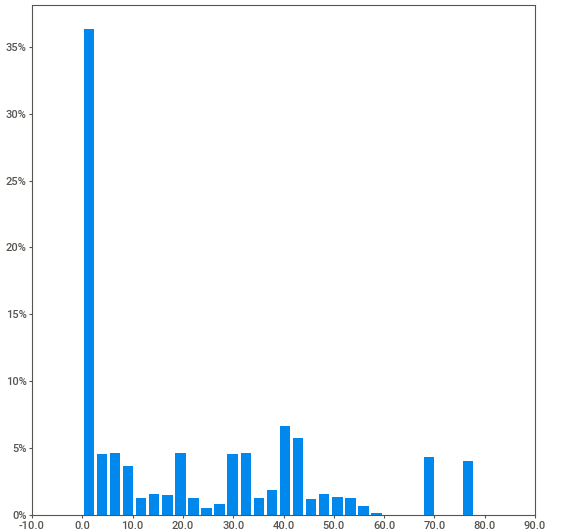
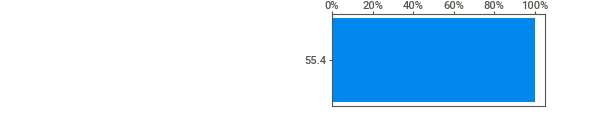
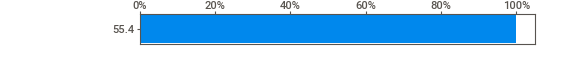
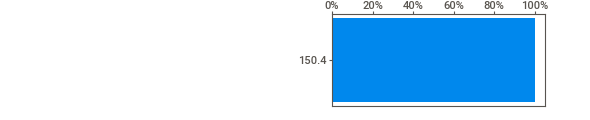
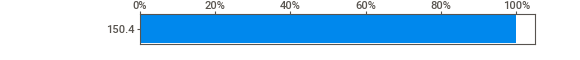
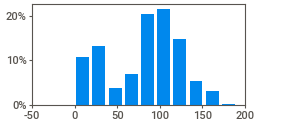
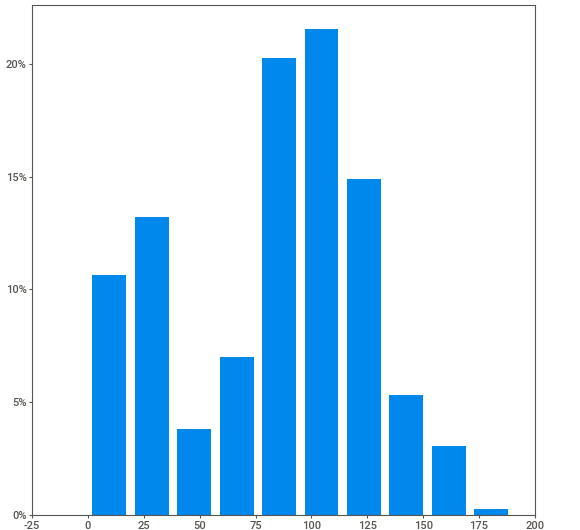
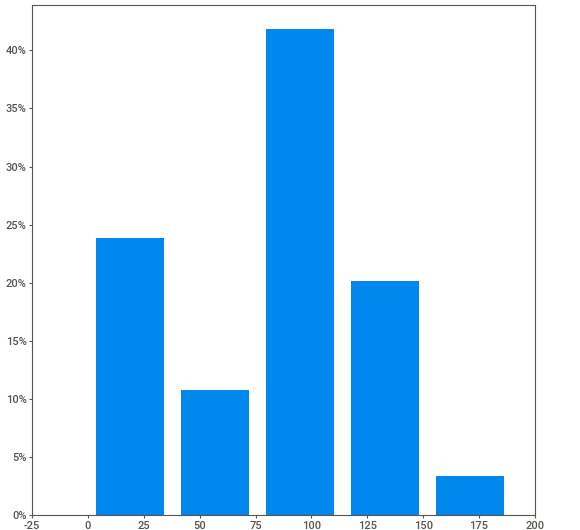
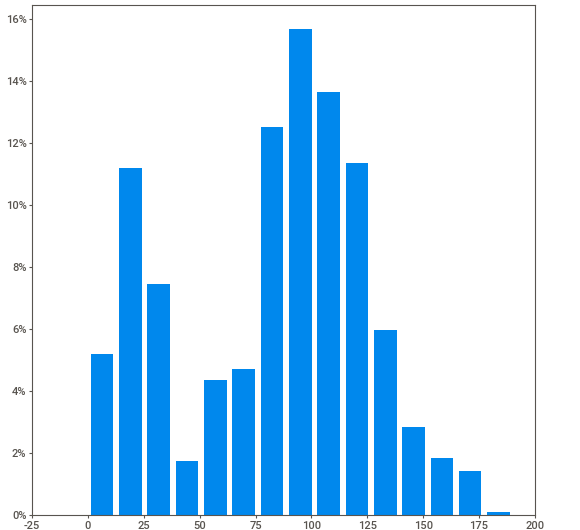
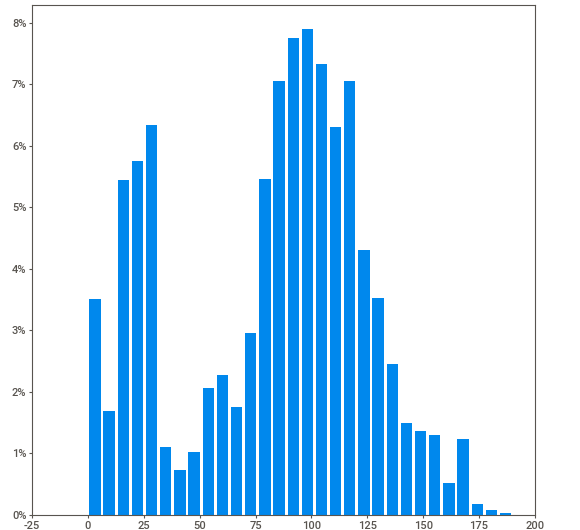
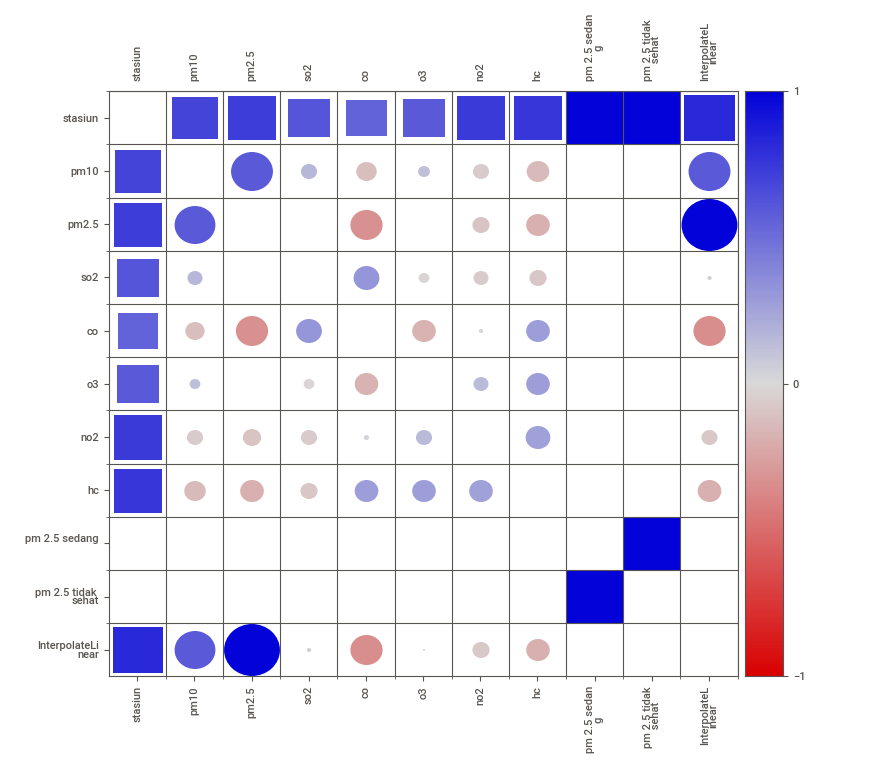
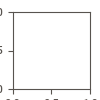

In [10]:
my_report = sv.analyze(processed_df)
my_report.show_notebook()

## Lagged Scatter Plot

d:\0_amri_local\11_aqi_forecast\notebooks\helper_functions\visualization.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[lagged_param_name] = temp_df[parameter].shift(shift)


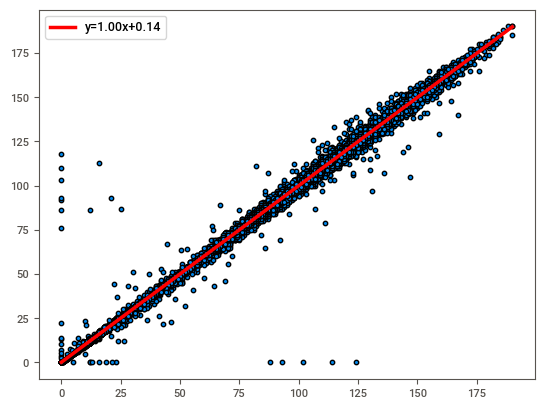

In [13]:
visualization.plot_lagged_scatter(
    processed_df,
    visualization.reg_line,
    parameter="InterpolateLinear",
)

## Overall Plot

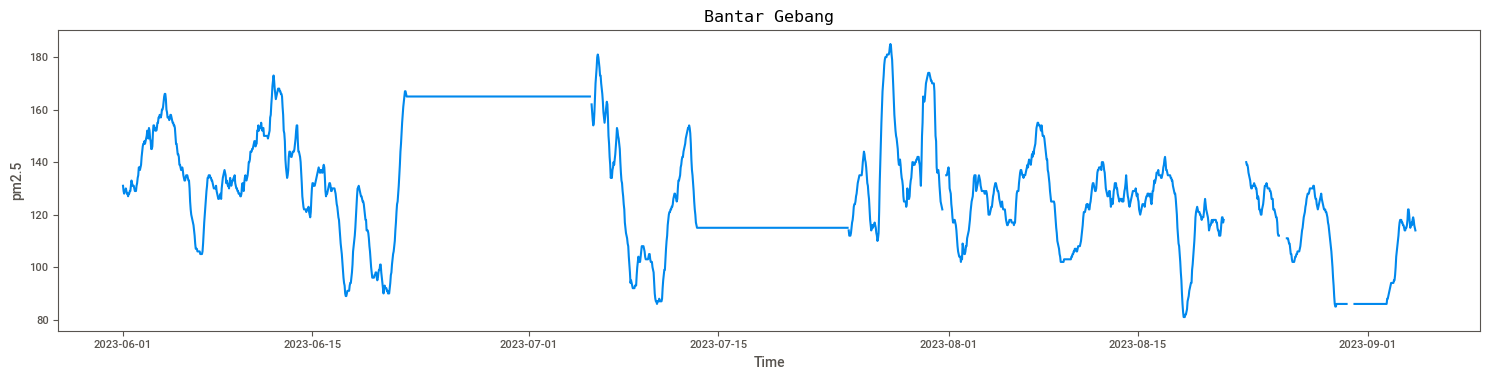

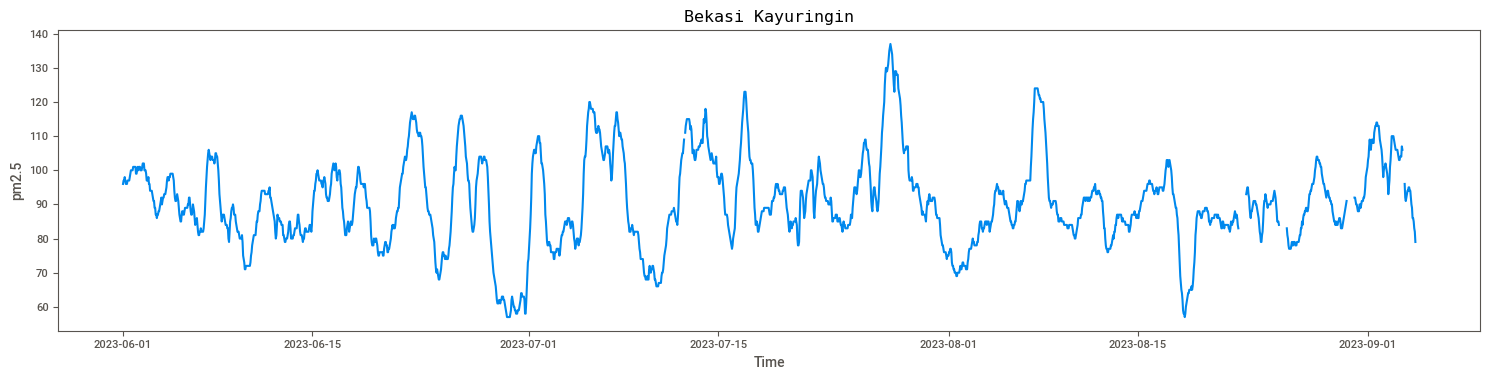

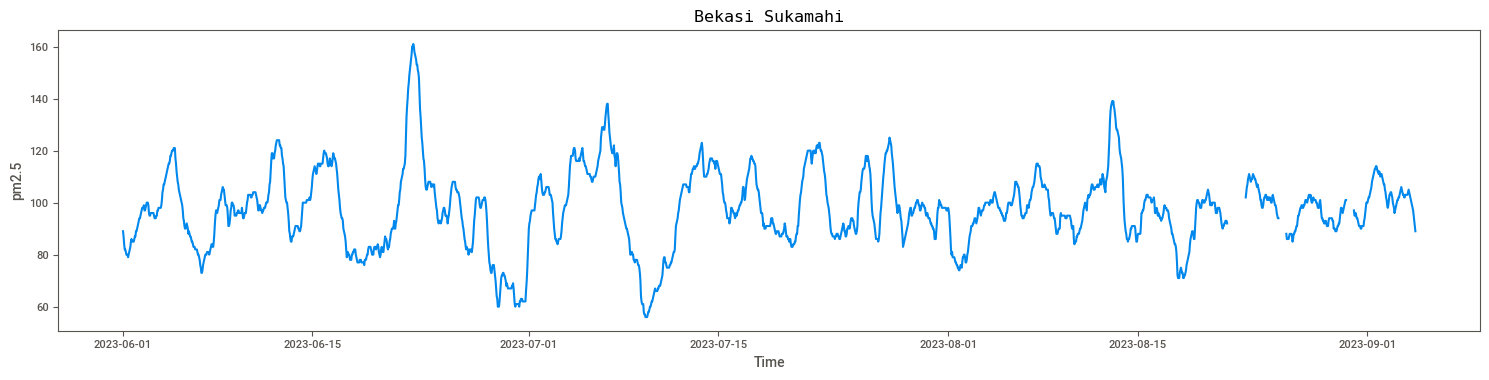

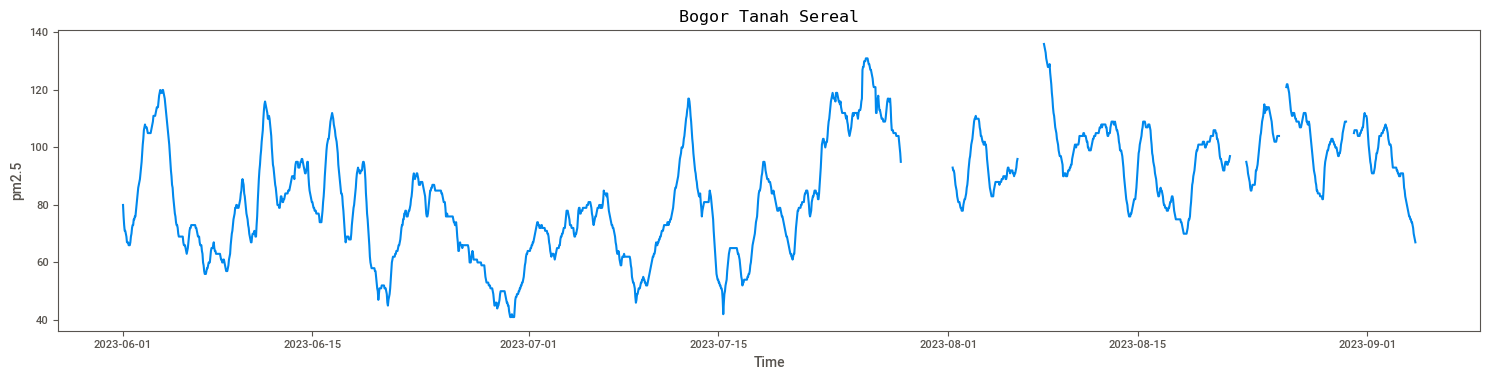

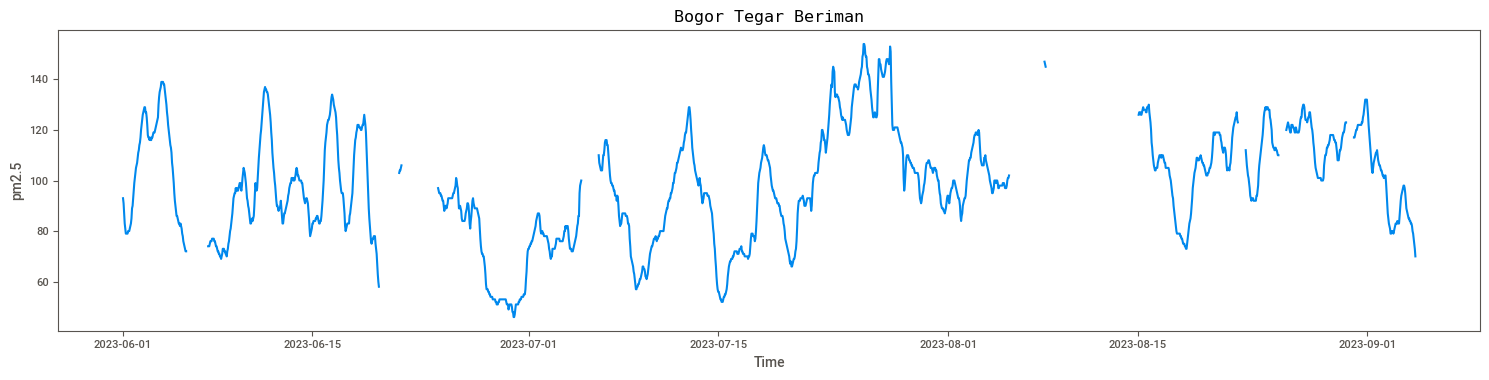

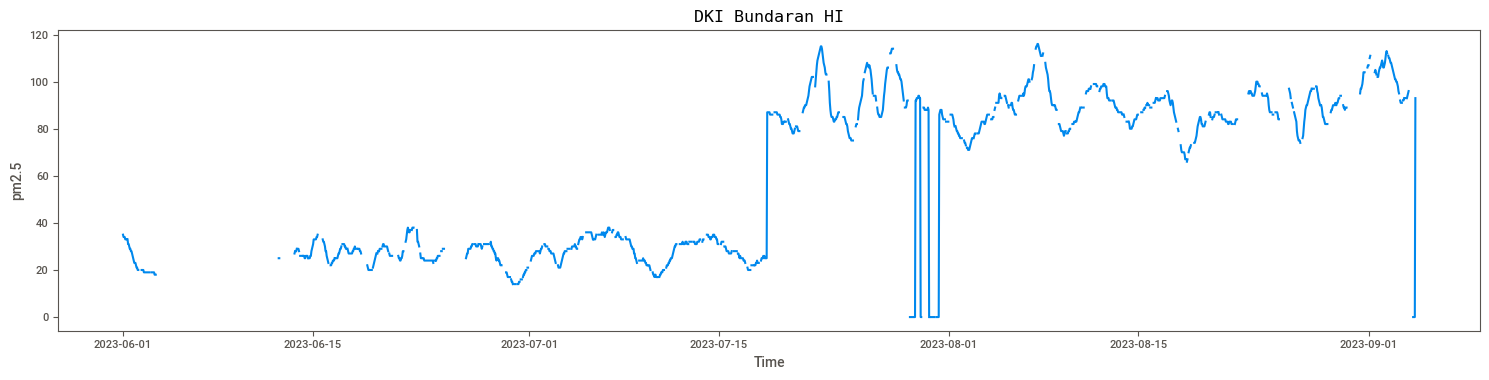

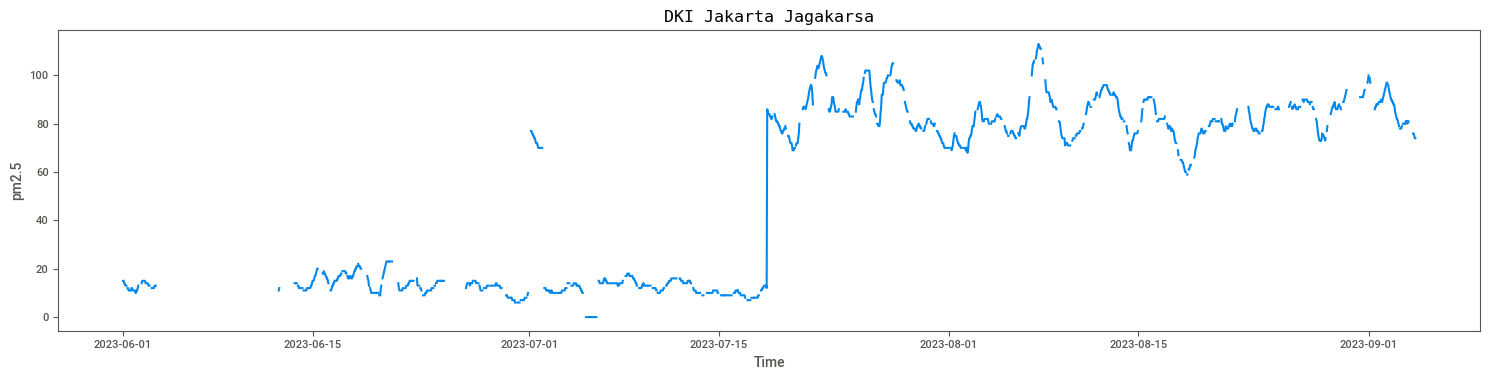

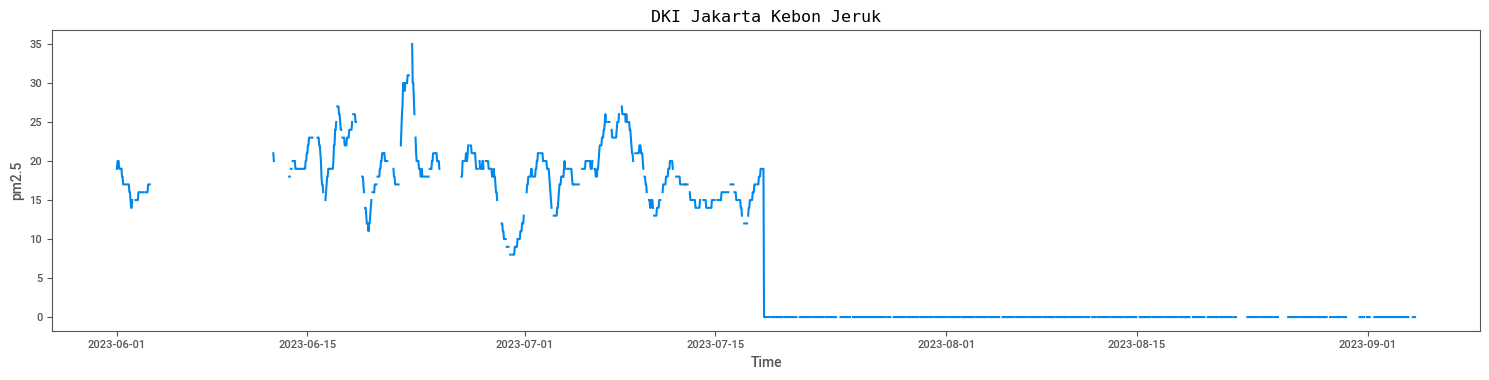

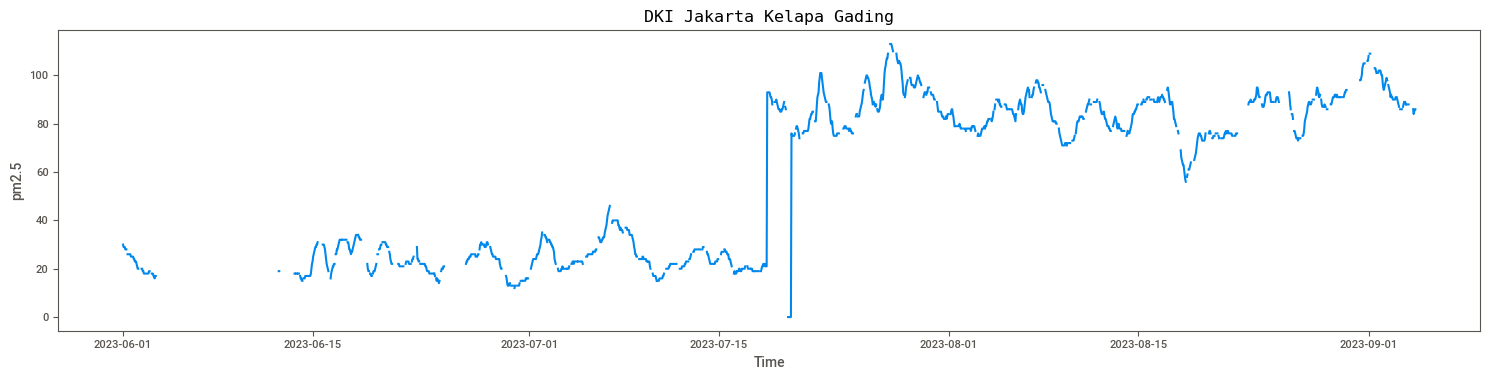

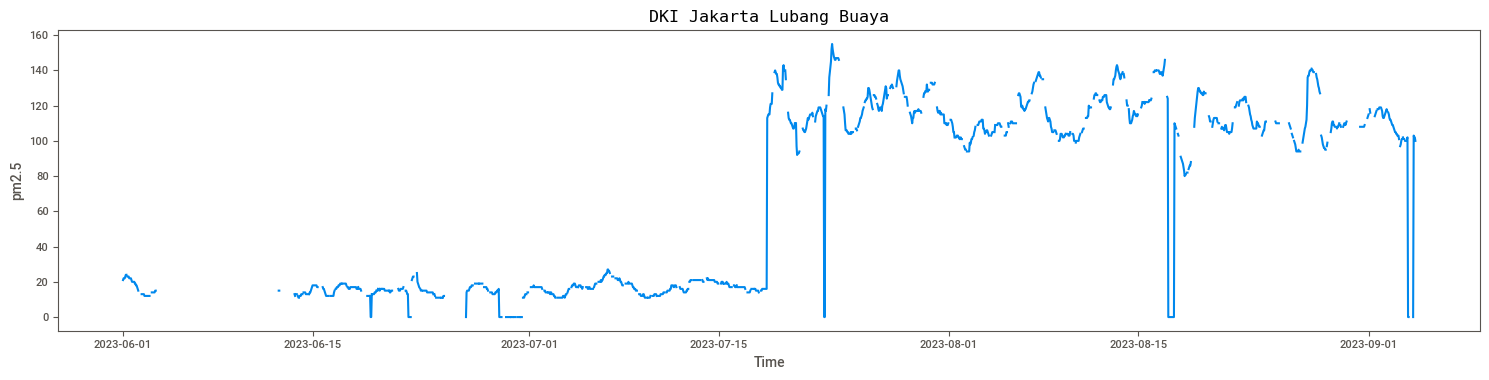

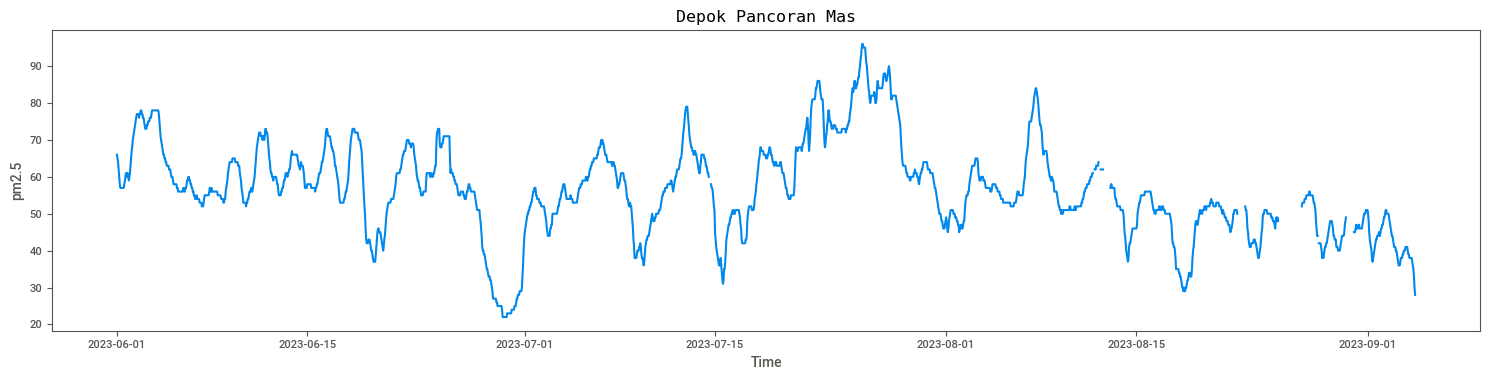

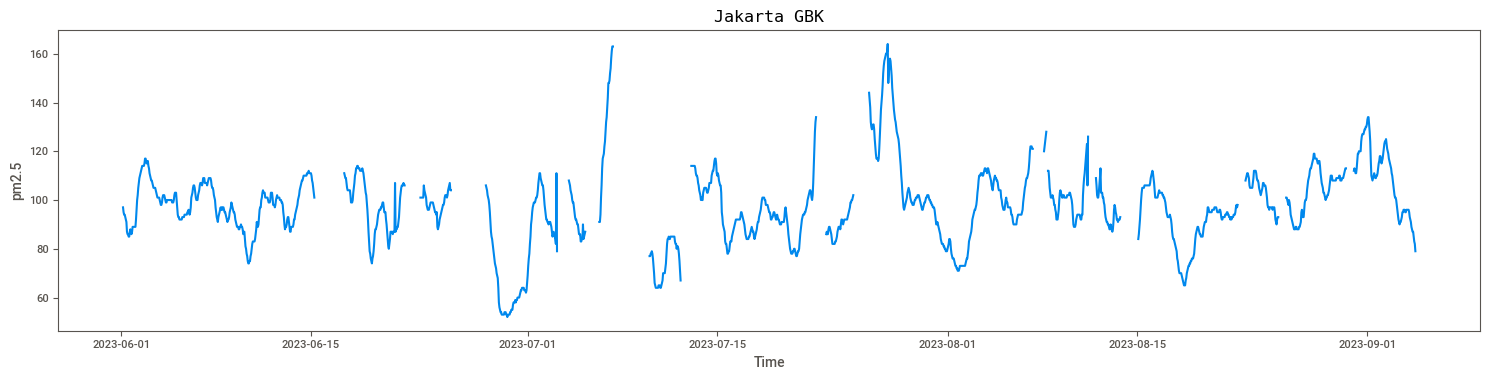

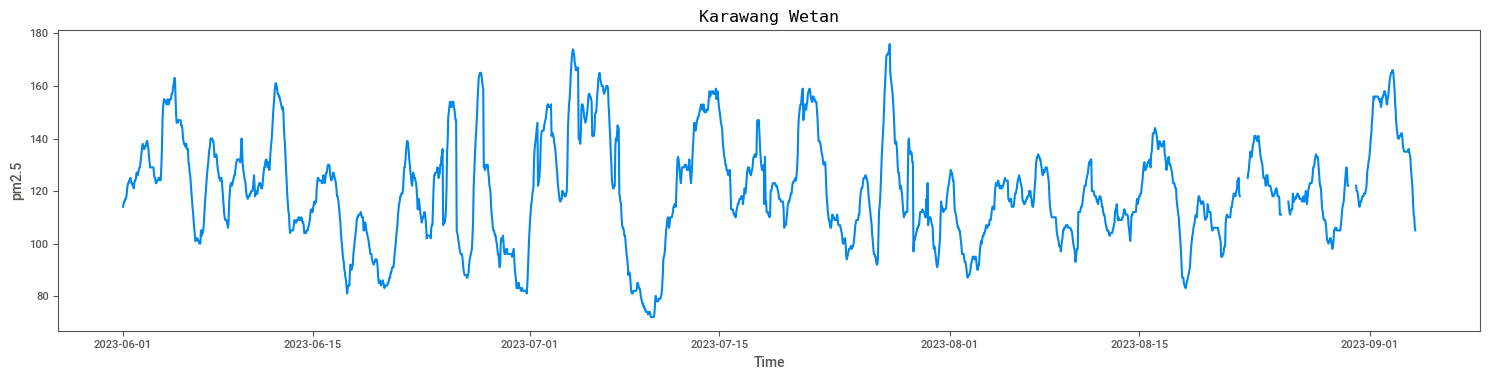

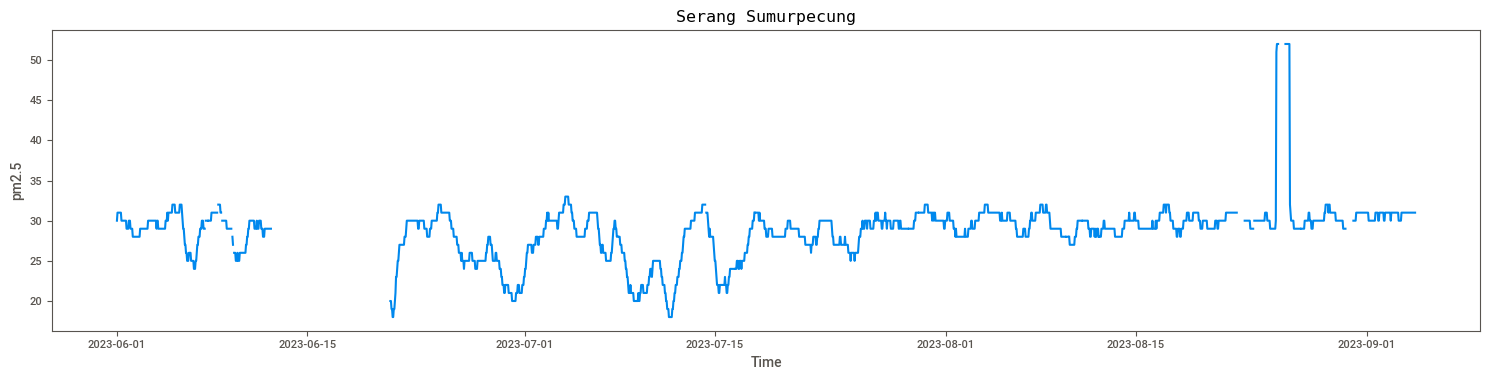

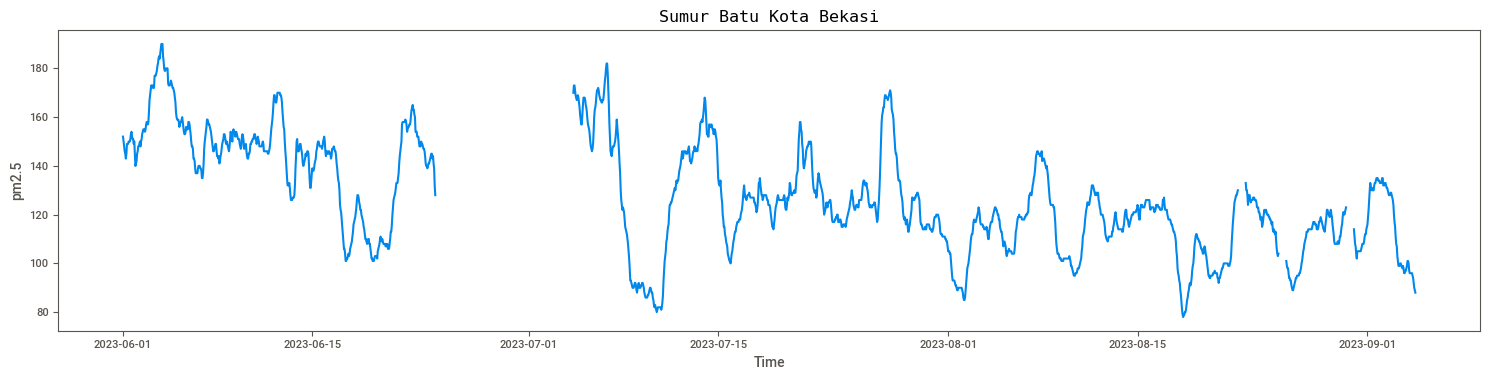

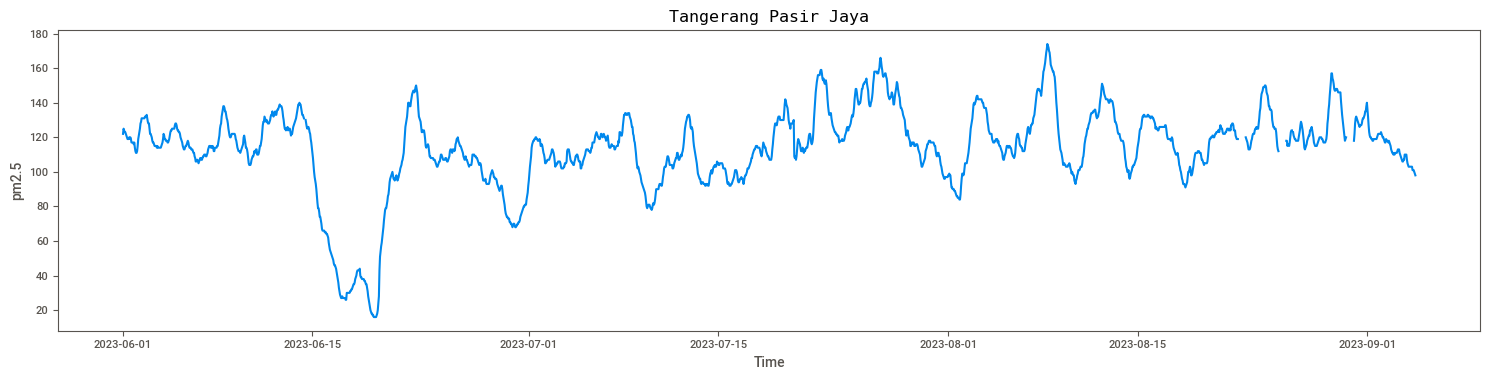

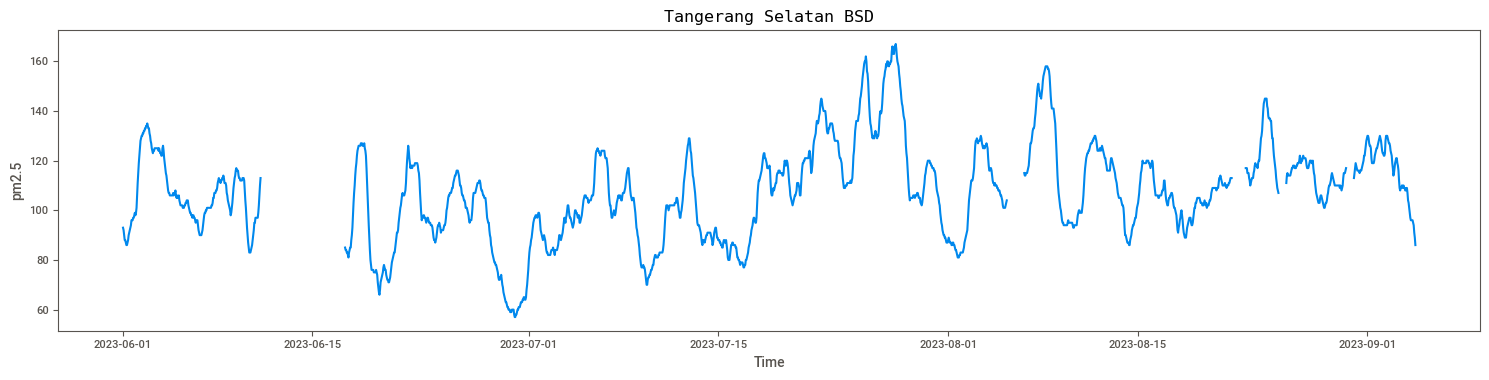

In [14]:
for stasiun in processed_df['stasiun'].unique():
    fig, ax = visualization.overall_plot(
        processed_df[processed_df['stasiun']==stasiun],
        'read_time',
        ["pm2.5"],
        1
    )
    ax.set_title(stasiun)

In [21]:
used_stasiun = "Bekasi Kayuringin"
filtered_df = processed_df[processed_df['stasiun']==used_stasiun]

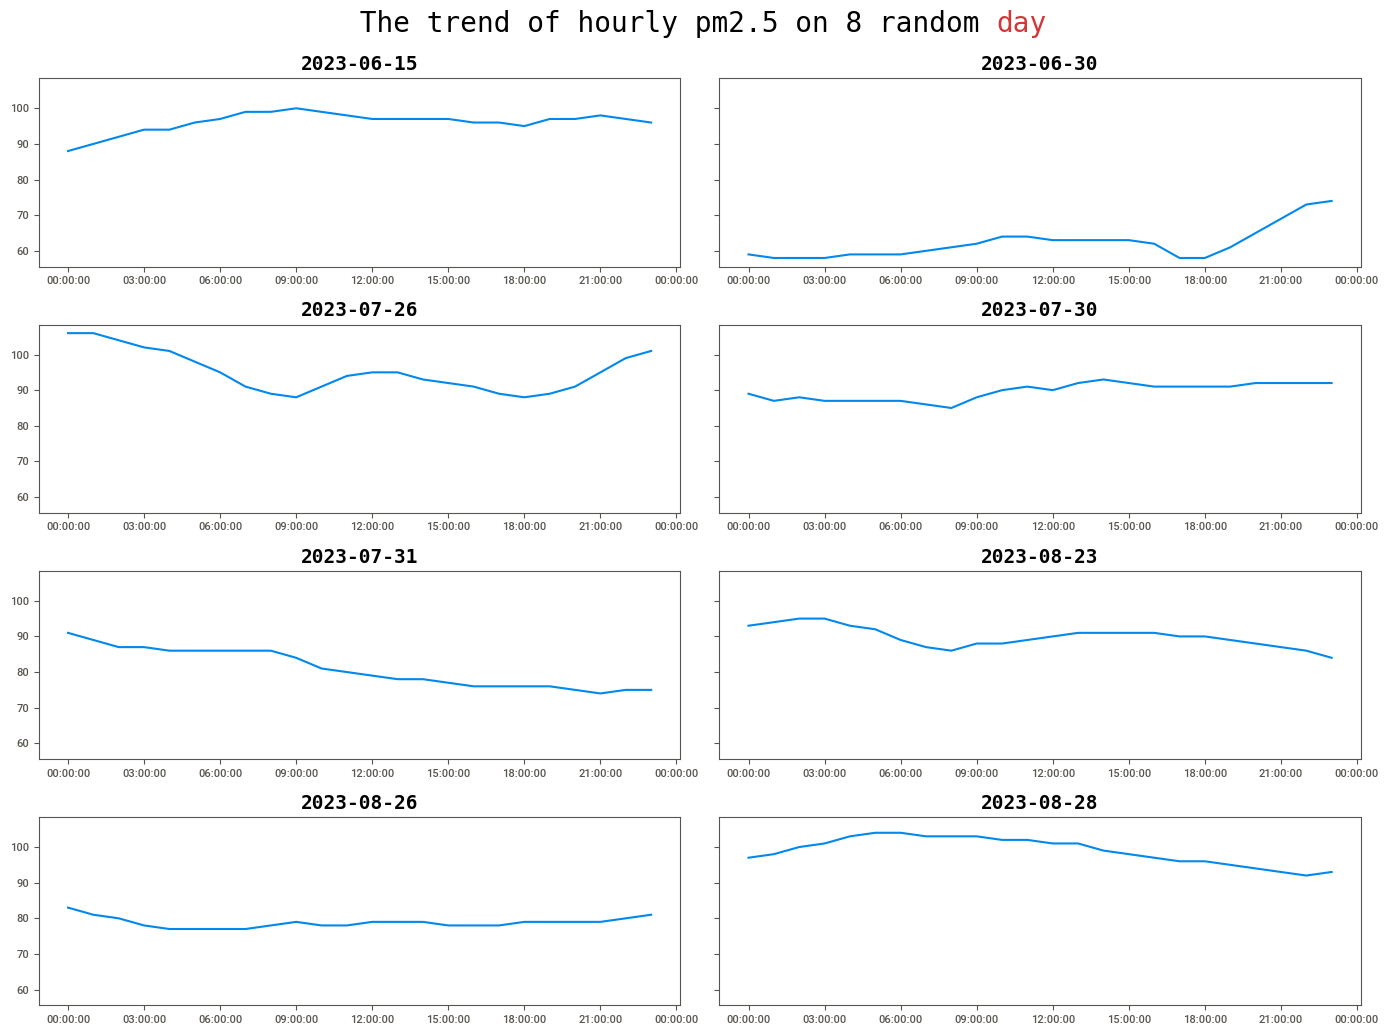

In [22]:
visualization.timely_plot(
    df = filtered_df,
    time_granularity='day',
    x='read_time',
    y='pm2.5'
)

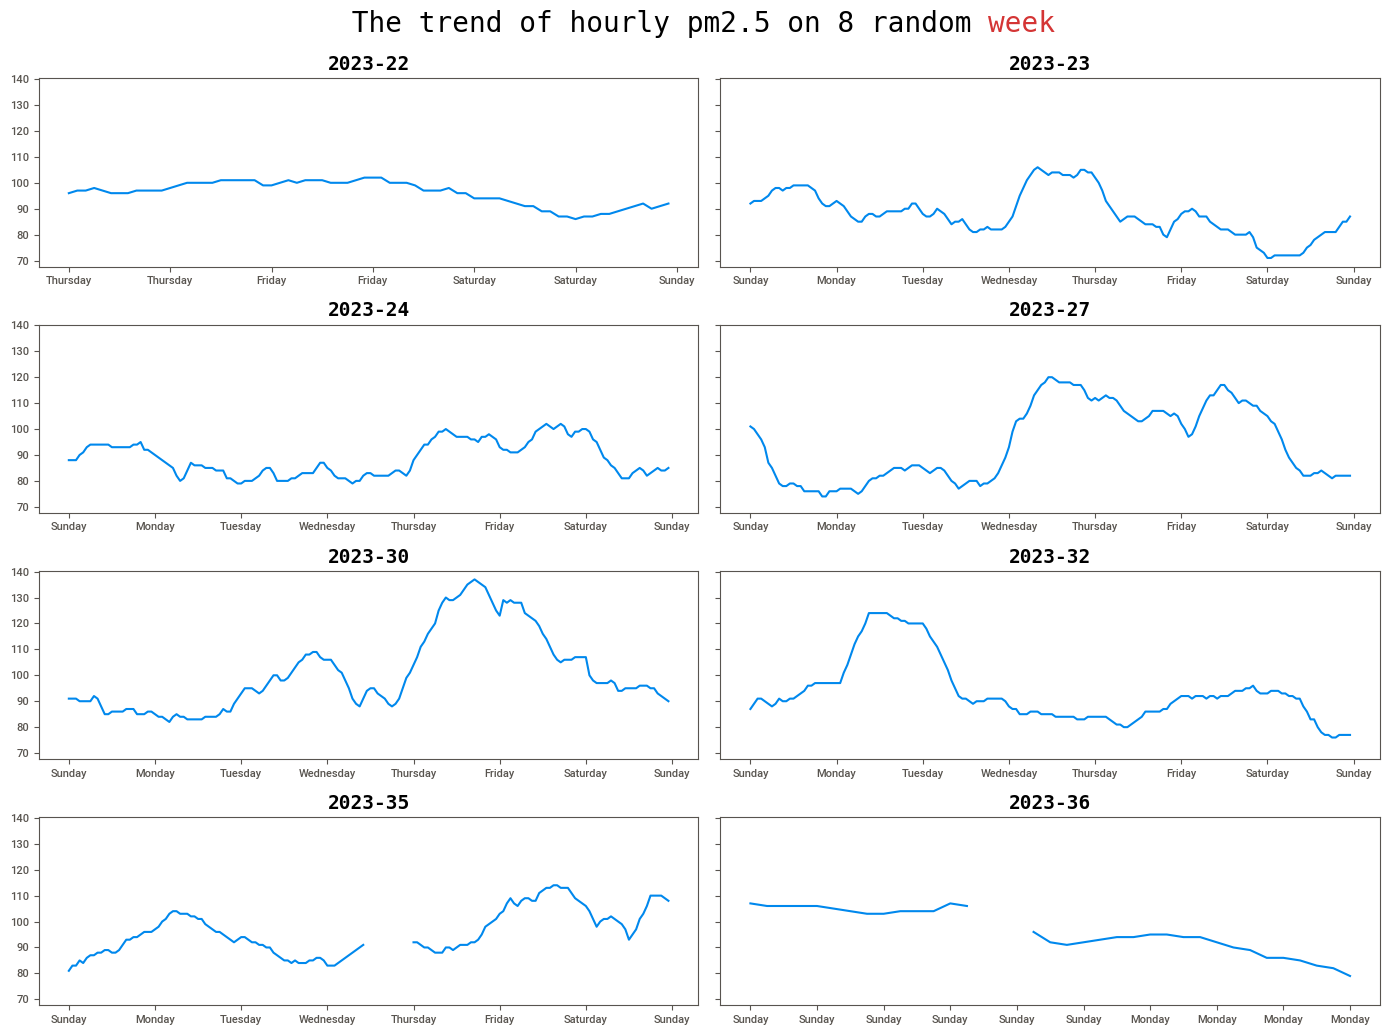

In [23]:
visualization.timely_plot(
    df = filtered_df,
    time_granularity='week',
    x='read_time',
    y='pm2.5'
)

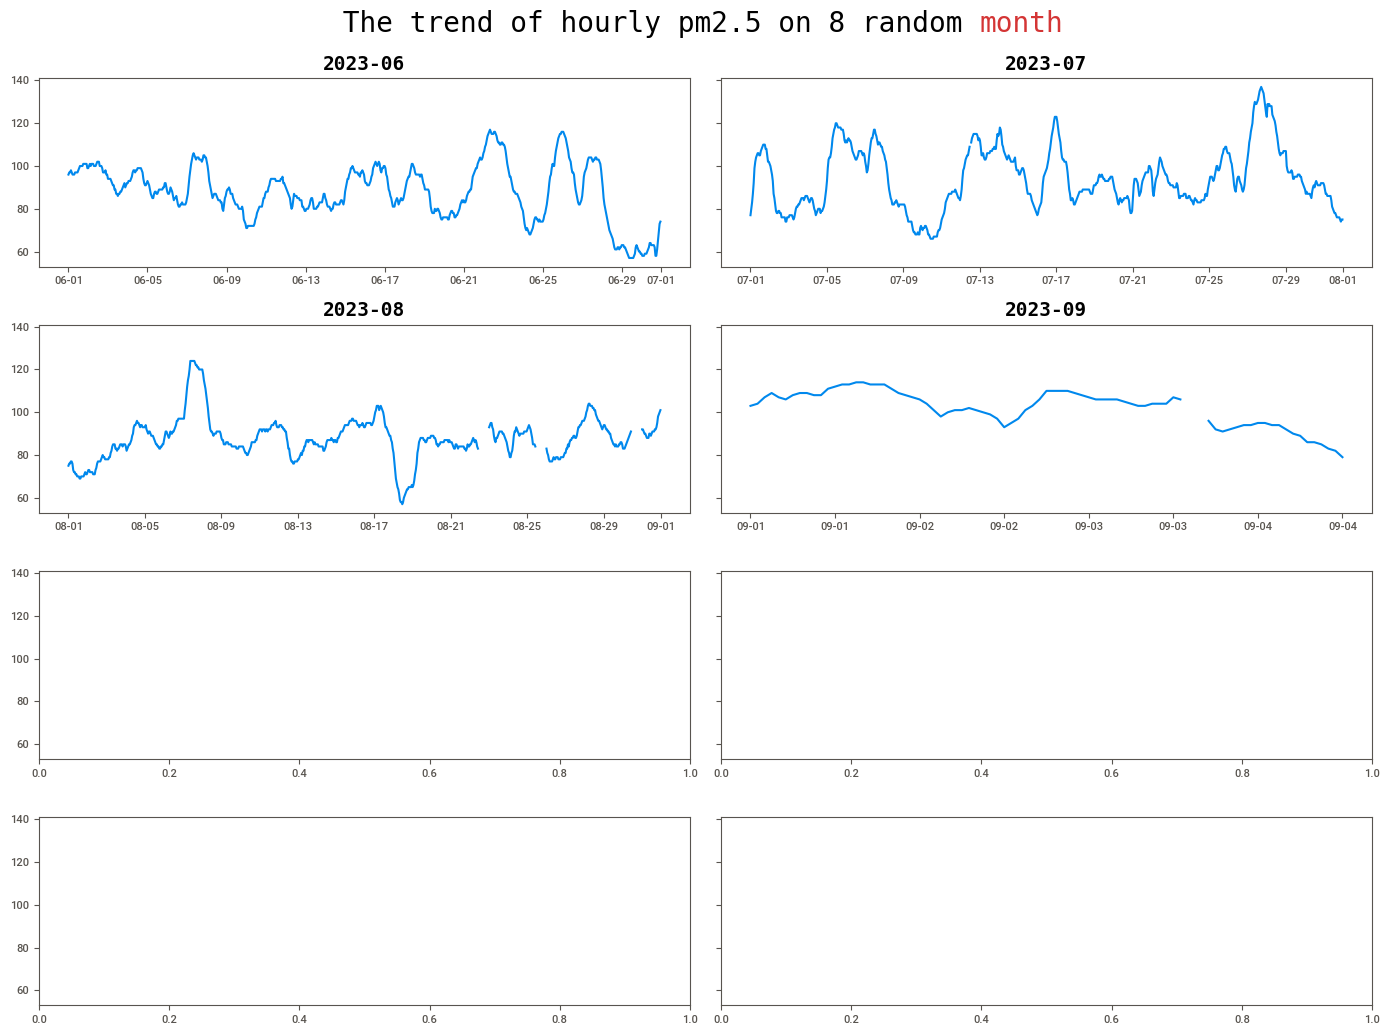

In [24]:
visualization.timely_plot(
    df = filtered_df,
    time_granularity='month',
    x='read_time',
    y='pm2.5'
)

## Heatmap Correlation Matrix

In [16]:
numeric_columns = processed_df.select_dtypes(include=['number'])#.drop(columns=['unnamed: 0'])

Text(0.5, 1.0, 'Correlation Matrix Heatmap for pm2.5 vs. Other Columns')

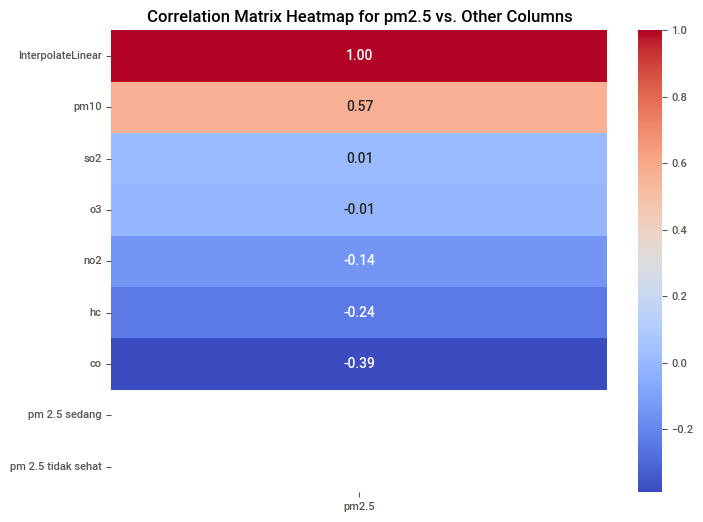

In [17]:
target_column = 'pm2.5'
correlations = pd.DataFrame(numeric_columns.corr()[target_column])
correlations = correlations.sort_values(by=target_column, ascending=False)
correlations.drop([target_column], inplace=True)
# correlations

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'Correlation Matrix Heatmap for {target_column} vs. Other Columns')

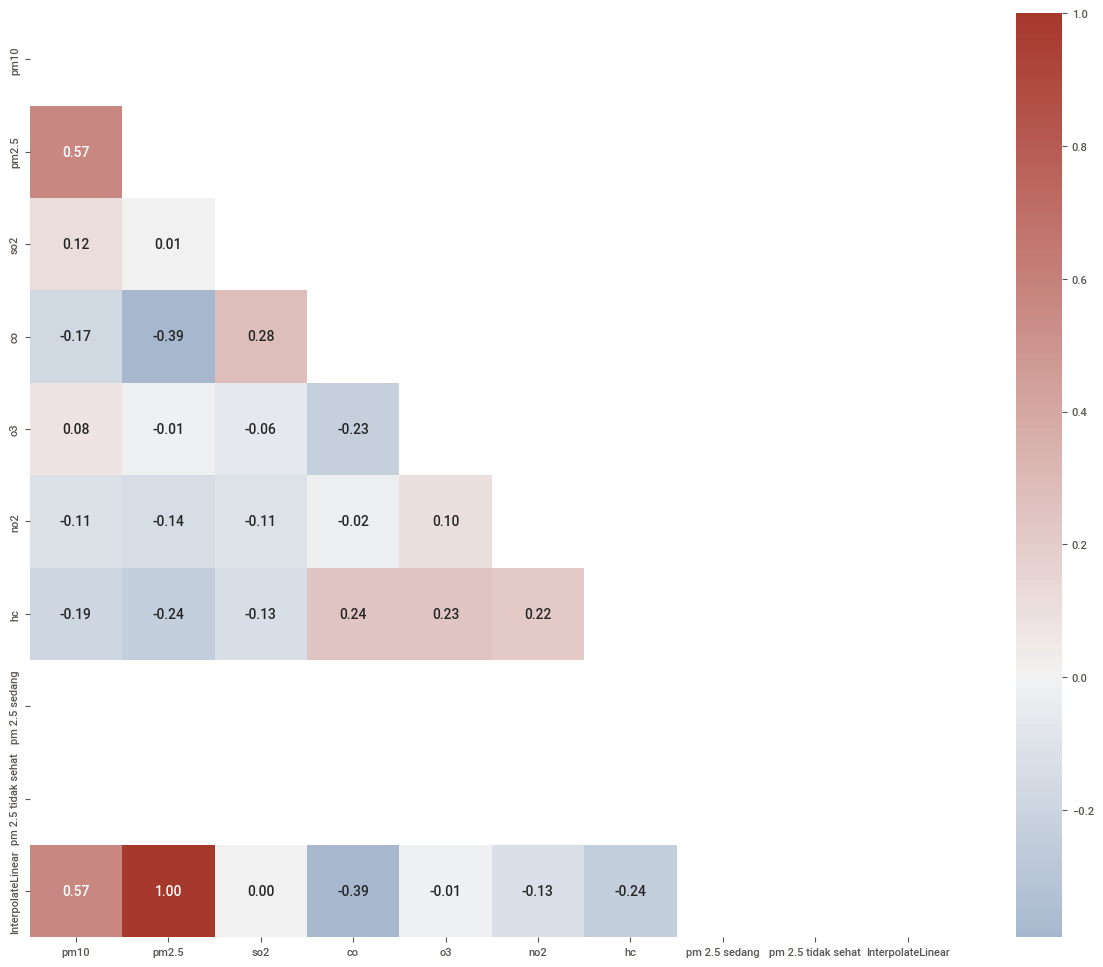

In [18]:
visualization.plot_correlation_heatmap(numeric_columns)

# Export raw df as processed df

In [36]:
stasiun_name = used_stasiun.lower().replace(" ","_")
processed_file_name = f"klhk_{stasiun_name}.csv"
processed_file_path = processed_data_dir / processed_file_name

if not os.path.exists(processed_file_path):
    filtered_df.to_csv(processed_file_path)
else:
    print("File already exist!")